# Laboratorio 2 - Perceptrón para clasificar lirios - Práctica 3

Grupo B07

- Álvaro Ramos Morales

- Álvaro Delgado Gallego

- Fernando Ramírez Fernández

- Juan Esteban Bernal Santos

In [114]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.python.client import device_lib
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [115]:


#leer datos
data = pd.read_csv('infarto.csv', delimiter=';', na_values='N/A')
data = data.dropna()
data = data.drop(columns=['id'])
#quitamos el nsnc
data = data[data.uso_tabaco != 'NSNC']

data.head(5)

,genero,edad,hipertensión,enfermedad_coronaria,casado,trabajo,residencia,nivel_glucosa,bmi,uso_tabaco,infarto
0,Masculino,67.0,0,1,Si,Privado,Urbana,228.69,36.6,Ex fumador,1
2,Masculino,80.0,0,1,Si,Privado,Rural,105.92,32.5,Nunca,1
3,Femenino,49.0,0,0,Si,Privado,Urbana,171.23,34.4,Fumador,1
4,Femenino,79.0,1,0,Si,Autonomo,Rural,174.12,24.0,Nunca,1
5,Masculino,81.0,0,0,Si,Privado,Urbana,186.21,29.0,Ex fumador,1


PREPROCESAMIENTO

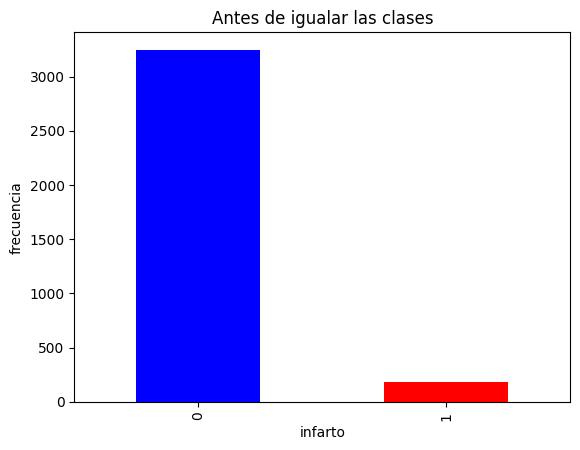

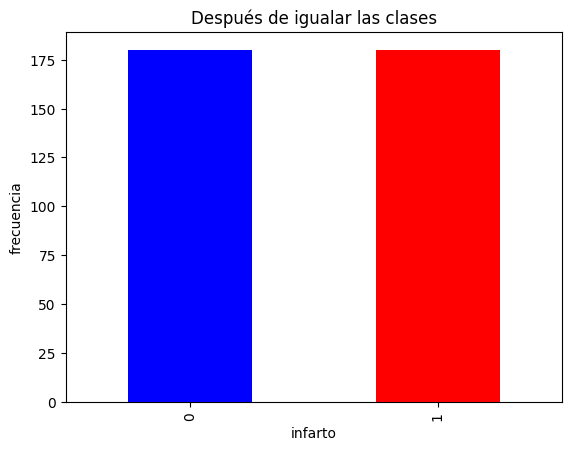

In [116]:
#HISTOGRAMA PARA VER LA DIFERENCIA DE CLASES 
data['infarto'].value_counts().plot(kind='bar', color=['blue', 'red'])
#añadir las etiquetas
plt.xlabel('infarto')
plt.ylabel('frecuencia')
plt.title('Antes de igualar las clases')
plt.show()

#igualar la cantidad de datos de cada clase
#seleccionar los datos de la clase 0 y seleccionar la misma cantidad de datos de la clase 1 para igualar las clases
data = pd.concat([data[data['infarto'] == 0].sample(n=data['infarto'].value_counts()[1]), data[data['infarto'] == 1]])
data = data.sample(frac=1)

#mostar el histograma para ver la diferencia de clases
data['infarto'].value_counts().plot(kind='bar', color=['blue', 'red'])
#añadir las etiquetas
plt.title('Después de igualar las clases')
plt.xlabel('infarto')
plt.ylabel('frecuencia')
plt.show()



Convertir a numerica las categoricas, usamos labelencoder para las varibles binarias y onehotencoder para las multi variable.

In [117]:
# Instanciar el codificador para cada columna categórica
enc = OneHotEncoder()
label_enc = LabelEncoder()

# Codificar las columnas categóricas binarias
data['genero'] = label_enc.fit_transform(data['genero'])
data['casado'] = label_enc.fit_transform(data['casado'])
data['residencia'] = label_enc.fit_transform(data['residencia'])

# Selección de las columnas para la codificación
multi_categorical_columns = ['uso_tabaco', 'trabajo']


# Ajustar el encoder y transformar los datos
multi_categorical_encoded = enc.fit_transform(data[multi_categorical_columns])

multi_categorical_encoded_df = pd.DataFrame(multi_categorical_encoded.toarray(), columns=enc.get_feature_names_out(multi_categorical_columns))

# Resetear índices si se modificó 'data'
data.reset_index(drop=True, inplace=True)
multi_categorical_encoded_df.reset_index(drop=True, inplace=True)

# Concatenar los DataFrames
data = pd.concat([data.drop(multi_categorical_columns, axis=1), multi_categorical_encoded_df], axis=1)

# Normalizar todas las columnas
data = (data - data.min()) / (data.max() - data.min())


data.head(5)

,genero,edad,hipertensión,enfermedad_coronaria,casado,residencia,nivel_glucosa,bmi,infarto,uso_tabaco_Ex fumador,uso_tabaco_Fumador,uso_tabaco_Nunca,trabajo_Autonomo,trabajo_Funcionario,trabajo_Menor de edad,trabajo_Privado
0,1.0,0.736111,1.0,0.0,1.0,0.0,0.022862,0.221176,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.541667,0.0,0.0,1.0,1.0,0.605487,0.698824,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.791667,1.0,0.0,1.0,0.0,0.572234,0.329412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.819444,0.0,1.0,1.0,1.0,0.651718,0.263529,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.833333,0.0,1.0,1.0,0.0,0.849113,0.282353,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [118]:
# Dividir los datos en características y etiqueta
X = data.drop('infarto', axis=1)
y = data['infarto']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#divir el train en train y validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)





Creamos el modelo

In [119]:
class MLPClassifier:
    def __init__(self, input_dim, nl=1, nn=1, activation='relu', optimizer='adam', loss='mean_squared_error'):
        self.input_dim = input_dim
        self.nl = nl  # Número de capas ocultas
        self.nn = nn  # Número de neuronas en cada capa oculta
        self.activation = activation
        self.optimizer = optimizer
        self.loss = loss

    def create_model(self):
        model = Sequential()
        # Agregar la capa de entrada
        model.add(Dense(self.nn, input_dim=self.input_dim, activation=self.activation))
        
        # Agregar capas ocultas según el número especificado en nl
        for _ in range(self.nl - 1):  # nl incluye todas las capas ocultas
            model.add(Dense(self.nn, activation=self.activation))
        
        # Agregar la capa de salida
        model.add(Dense(1, activation='sigmoid'))  # Usualmente para problemas de clasificación binaria usamos 'sigmoid'

        # Compilar el modelo
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        return model
    


In [120]:
def build_keras_classifier(input_dim):
    def model(nl=1, nn=1):
        mlp = MLPClassifier(input_dim=input_dim, nl=nl, nn=nn)
        return mlp.create_model()
    return model
    
# Asegúrate de que `X_train` está definido y accesible en este contexto.
input_dim = X_train.shape[1]  

keras_model = KerasClassifier(
    model=build_keras_classifier(input_dim),
    epochs=100,
    batch_size=10,
    verbose=0
)

In [121]:


param_grid = {
    'model__nl': [2, 5, 10],  # Número de capas ocultas
    'model__nn': [128, 256, 512]  # Número de neuronas por capa oculta
}

#
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Imprimir los resultados de la búsqueda en cuadrícula
print("Mejor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


c:\Users\delga\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\delga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Mejor: 0.621497 usando {'model__nl': 10, 'model__nn': 512}


Matriz de confusión

In [122]:
# Obtener las predicciones del modelo con los mejores parámetros
y_pred = grid_result.best_estimator_.predict(X_test)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

y_train_pred = grid_result.best_estimator_.predict(X_train)
y_train_pred_binary = np.where(y_train_pred > 0.5, 1, 0)

# Calcular la matriz de confusión validacion
y_val_pred = grid_result.best_estimator_.predict(X_val)
y_val_pred_binary = np.where(y_val_pred > 0.5, 1, 0)

# Convertir y_test a un array de numpy
y_test_array = y_test.values
y_train_array = y_train.values
y_val_array = y_val.values

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_array, y_pred_binary)
print("Matriz de Confusión test:")
print(conf_matrix)

# Calcular la matriz de confusión
conf_matrix_train = confusion_matrix(y_train_array, y_train_pred_binary)
print("Matriz de Confusión train:")
print(conf_matrix_train)

conf_matrix_val = confusion_matrix(y_val_array, y_val_pred_binary)
print("Matriz de Confusión val:")
print(conf_matrix_val)


Matriz de Confusión test:
[[21 12]
 [12 27]]
Matriz de Confusión train:
[[111  12]
 [ 13  94]]
Matriz de Confusión val:
[[17  7]
 [ 9 25]]


In [123]:
#mostrar la tabla con la precisión, sensibilidad y especificidad del test y train
table = [['', 'Precision', 'Sensibilidad', 'Especificidad'],
                ['Test', accuracy_score(y_test_array, y_pred_binary), conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1]), conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])],
                ['Train', accuracy_score(y_train_array, y_train_pred_binary), conf_matrix_train[1, 1] / (conf_matrix_train[1, 1] + conf_matrix_train[0, 1]), conf_matrix_train[0, 0] / (conf_matrix_train[0, 0] + conf_matrix_train[1, 0])],
                ['Val', accuracy_score(y_val_array, y_val_pred_binary), conf_matrix_val[1, 1] / (conf_matrix_val[1, 1] + conf_matrix_val[0, 1]), conf_matrix_val[0, 0] / (conf_matrix_val[0, 0] + conf_matrix_val[1, 0])]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))





╒═══════╤═════════════╤════════════════╤═════════════════╕
│       │   Precision │   Sensibilidad │   Especificidad │
╞═══════╪═════════════╪════════════════╪═════════════════╡
│ Test  │    0.666667 │       0.692308 │        0.636364 │
├───────┼─────────────┼────────────────┼─────────────────┤
│ Train │    0.891304 │       0.886792 │        0.895161 │
├───────┼─────────────┼────────────────┼─────────────────┤
│ Val   │    0.724138 │       0.78125  │        0.653846 │
╘═══════╧═════════════╧════════════════╧═════════════════╛
